In [ ]:
#Загрузка библиотек:
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Считываение картинок:
imgs_path = "/content/images10k/"
imgs_model_width, imgs_model_height = 224, 224
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

# EDA и визуализация

In [ ]:
#Чтение характеристик фотографий:
styles = pd.read_csv("/styles.csv", error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 1

# Товары для мужчин vs товары для женщин

In [ ]:
#Распределение товаров по гендерному признаку:
fig = px.pie(styles, styles['gender'], color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title="Распределение товаров", width=800, height=800, font=dict(family="Segoe UI semilight", size=16))
fig.show()

In [ ]:
catcounts=pd.value_counts(styles['masterCategory'])

# Наиболее популярные категории

In [ ]:
#Столбатая диаграмма популрности категорий:
fig = go.Figure([go.Bar(x=catcounts.index, y=catcounts.values, text=catcounts.values, marker_color='darkkhaki')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Топ категории", width=1000, height=900, xaxis_title='Категория',
                  yaxis_title='Количество покупок', font=dict(family="Segoe UI semilight", size=16))
fig.show()

Большей популярностью пользуется одежда. 

# High season покупок

In [ ]:
seasons=pd.value_counts(styles['season'])

fig = go.Figure(data=[go.Scatter(x=seasons.index, y=seasons.values, mode='markers', 
    marker=dict(color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
                opacity=[0.6, 0.7, 0.8, 1], size=[123, 65, 49, 17]))])
fig.update_layout(width=900, height=900, title="Зависимость количества покупок от времени года", xaxis_title='Сезон', yaxis_title='Количество',
                  font=dict(family="Segoe UI semilight", size=16))
fig.show()

Около 3/4 (75,55 %) товаров покупаются летом и осенью.

# Наиболее популярные типы товаров

In [ ]:
#Столбчатая диаграмма популярности типов товаров:
articles = pd.value_counts(styles['articleType'])
fig = go.Figure([go.Bar(x=articles.index[:15], y=articles.values[:15], text=articles.values[:15], marker_color='darkmagenta')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Топ 15 категорий", xaxis_title='Категория', yaxis_title='Количество покупок',
                  width=950, height=750, font=dict(family="Segoe UI semilight", size=16))
fig.show()

Футболки и рубашки - лидеры продаж. Очевидно, это наиболее подходящая одежда для лета и осени в регионе.

# Извлечение признаков одного изображения

Для сокращения времени выполнения алгоритма сократим данные до 100 изображений для предотвращения остановки ядра

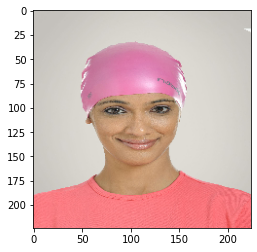

Пример данных


In [ ]:
files=files[0:100]
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("Пример данных")

На вход сети будут подаваться 3-х канальные изображения 224х224 

In [ ]:
# Подгрузим сеть ImageNet с весами
vgg_model = vgg16.VGG16(weights='imagenet');
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output);
feat_extractor.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

С помощью **preprocess_input** изображения преобразуются из RGB в BGR, затем каждый цветовой канал центрируется по отношению к набору данных ImageNet без масштабирования.

In [ ]:
#Рассчитаем размерность данных:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)
print('Размерность входных данных', image_batch.shape)
processed_image = preprocess_input(image_batch.copy())

Размерность входных данных (1, 224, 224, 3)


In [ ]:
img_features = feat_extractor.predict(processed_image)
print("Извлечены признаки одного изображения")
print("Количество признаков:", img_features.size)

Извлечены признаки одного изображения
Количество признаков: 4096


# Проделаем те же действия с множеством изображений

In [ ]:
#Извлечение признаков для множества изображений:
importedImages = []
for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)    
images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())

imgs_features = feat_extractor.predict(processed_imgs)
print("Признаки извлечены")
imgs_features.shape

Признаки извлечены


(100, 4096)

In [ ]:
#Извлечение признаков:
print("Извлечено", imgs_features.shape[0], "признаков для каждого из", imgs_features.shape[1], "изображений.")

Извлечено 100 признаков для каждого из 4096 изображений.


Подбор релевантных товаров осуществим на основе косинусного подобия - нормализованное скалярное произведение X и Y.

In [ ]:
#Подбор через косинусовое подобие:
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/images200/1581.jpg,/content/images200/1764.jpg,/content/images200/1607.jpg,/content/images200/1531.jpg,/content/images200/1598.jpg,/content/images200/1831.jpg,/content/images200/1595.jpg,/content/images200/1535.jpg,/content/images200/1841.jpg,/content/images200/1729.jpg,...,/content/images200/1799.jpg,/content/images200/1845.jpg,/content/images200/1760.jpg,/content/images200/1525.jpg,/content/images200/1550.jpg,/content/images200/1570.jpg,/content/images200/1565.jpg,/content/images200/1752.jpg,/content/images200/1578.jpg,/content/images200/1537.jpg
/content/images200/1581.jpg,1.000000,0.250802,0.222340,0.338072,0.143765,0.166073,0.340290,0.528010,0.149296,0.161942,...,0.216121,0.380084,0.378874,0.297302,0.234205,0.307222,0.295464,0.343382,0.361507,0.360990
/content/images200/1764.jpg,0.250802,1.000000,0.682622,0.584757,0.259885,0.265937,0.480578,0.231838,0.246379,0.271802,...,0.685419,0.491117,0.414064,0.384956,0.159066,0.473940,0.259977,0.562864,0.498975,0.549049
/content/images200/1607.jpg,0.222340,0.682622,1.000000,0.617837,0.198262,0.177909,0.481890,0.201138,0.215142,0.185494,...,0.560045,0.493707,0.385672,0.337409,0.077014,0.427522,0.206486,0.558582,0.473450,0.565751
/content/images200/1531.jpg,0.338072,0.584757,0.617837,1.000000,0.174133,0.214578,0.729313,0.275410,0.235150,0.216727,...,0.506915,0.802203,0.590869,0.318858,0.164762,0.539322,0.239954,0.851686,0.772899,0.882915
/content/images200/1598.jpg,0.143765,0.259885,0.198262,0.174133,1.000000,0.257987,0.257903,0.122621,0.278367,0.216454,...,0.207696,0.217068,0.264768,0.459425,0.190311,0.276783,0.483083,0.226744,0.254067,0.189037


In [ ]:
# Функция подбора 10 релевантных товаров на основе выбранного:
nb_closest_images = 10
def retrieve_relevant_products(given_img):
    print("     Выбранный товар")
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("    _____________________________")
    print("    Релевантные товары")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = 100*cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("     Схожесть: ", round(closest_imgs_scores[i],2), "%")
print('Повысим число выводимых релевантных товаров на 6 штук ради интереса')

Повысим число выводимых релевантных товаров на 6 штук ради интереса


     Выбранный товар


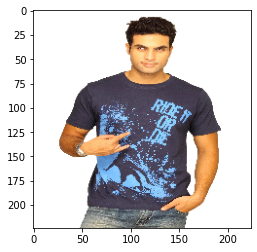

    _____________________________
    Релевантные товары


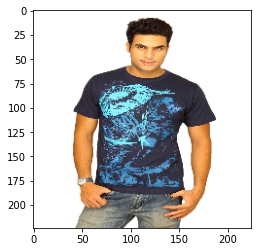

     Схожесть:  84.21 %


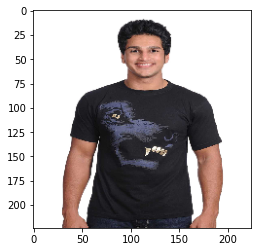

     Схожесть:  78.76 %


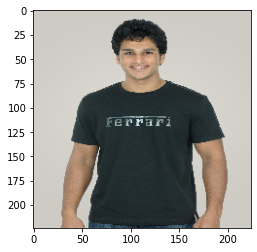

     Схожесть:  78.37 %


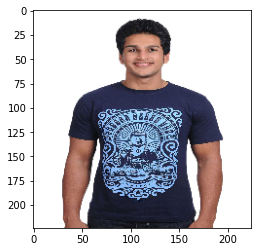

     Схожесть:  77.97 %


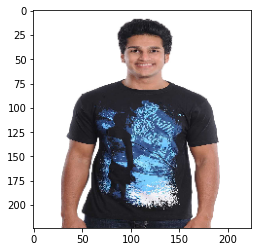

     Схожесть:  77.87 %


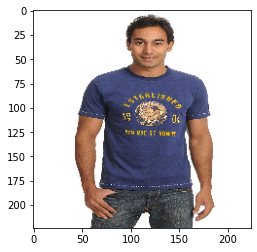

     Схожесть:  77.61 %


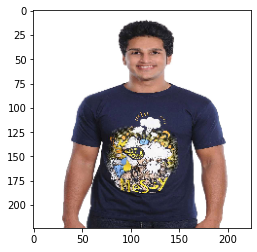

     Схожесть:  76.98 %


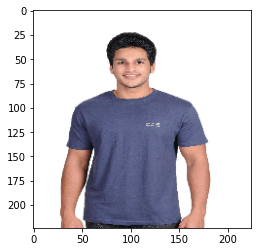

     Схожесть:  76.87 %


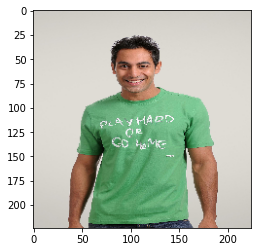

     Схожесть:  76.26 %


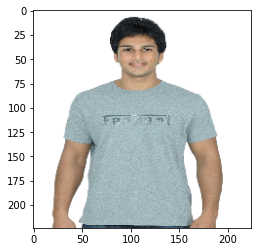

     Схожесть:  75.26 %


In [ ]:
#Визуализация работы модели товаром №1:
retrieve_relevant_products(files[49])

**С футболками нейронная сеть справилась отлично, так как они имеют примерно один фасон и телосложения моделей с ярко выраженными гендерными характеристками, носящих их. Отличие предметв кроется только в узорах и цветах принта.**

     Выбранный товар


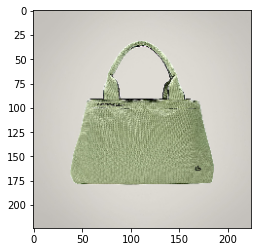

    _____________________________
    Релевантные товары


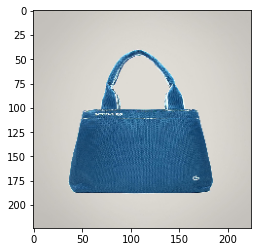

     Схожесть:  90.17 %


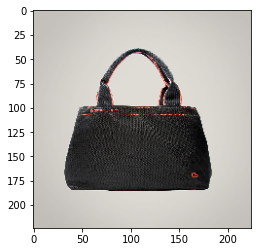

     Схожесть:  82.73 %


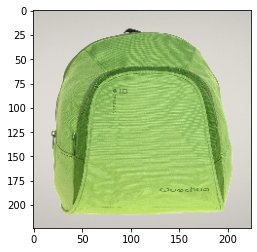

     Схожесть:  57.14 %


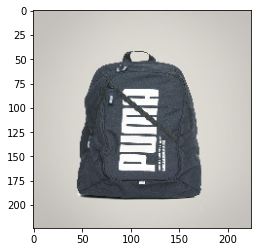

     Схожесть:  49.7 %


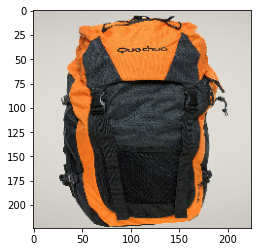

     Схожесть:  39.6 %


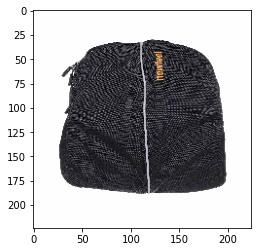

     Схожесть:  38.83 %


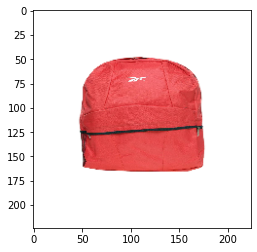

     Схожесть:  38.33 %


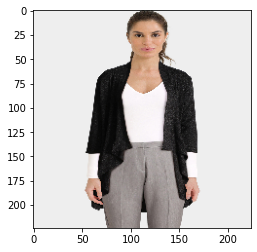

     Схожесть:  35.19 %


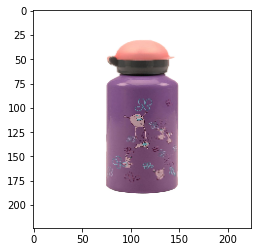

     Схожесть:  34.12 %


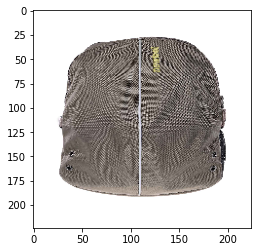

     Схожесть:  34.04 %


In [ ]:
#Визуализация работы модели с товаром №2:
retrieve_relevant_products(files[78])

**С сумками модель справилась значительно хуже: здесь нельзя так легко определить пол, так как на фотографиях нет моделей, а помимо вариаций цвета, есть огромные вариации типов и форм сумок от дамских сумок до туристических рюкзаков. Помимо этого, к релевантным предметам модель отнесла даже девушку-модель, распахнутая кофта которой напоминает лямки от рюкзака и спортивную бутылку для воды, которую с натяжкой тоже можно посчитать своеобразной сумкой для жидких предметов.
Таким образом, не на всех наборах данных модель успешно подбирает похожие товары, но всё на традиционных типах одежды она работает отлично.**